In [1]:
import torch, torchvision
import os
import random
import dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_v2 as loss_fn
from unet import UNET

In [ ]:
def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

def validate(model, validation_loader, transform, DEVICE):
    model.eval()
    with torch.no_grad():
        val_loss = []
        for images, masks, names in validation_loader:
            images = transform(images)
            outputs = model(images.to(DEVICE))
            #outputs = untransform(outputs)

            masks = masks.type(torch.LongTensor)
            masks = transform(masks)
            masks = torch.squeeze(masks, 1)

            vloss = criterion(outputs, masks.to(DEVICE))
            loss = vloss.detach().item()
            val_loss.append(loss)

        loss = np.mean(val_loss)
        # print("Validation loss before training: {}".format(loss))
    return loss

def train(model, training_loader, transforms, DEVICE, criterion, optimiser):
    model.train()
    train_loss = []
    for images, masks, names in training_loader:
        images = transform(images)
        outputs = model(images.to(DEVICE))
        #outputs = untransform(outputs)

        masks = masks.type(torch.LongTensor)
        masks = transform(masks)
        masks = torch.squeeze(masks, 1)

        tloss = criterion(outputs, masks.to(DEVICE))
        loss = tloss.detach().item()
        train_loss.append(loss)

        optimiser.zero_grad()
        tloss.backward()
        optimiser.step()

    loss = np.mean(train_loss)
    return loss

def evaluate(eval_model, testing_loader):
    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []

    eval_model.eval()
    for image, mask, name in testing_loader:
        prediction = predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
        pred = torch.from_numpy(prediction)

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))
    return precisions, recalls, F1s, IOUs

In [3]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

TERMS = ["p"]
SIZE = (384, 512)
FOLDS = [0,1,2,3,4]    # 0 to 4 only a few folds at a time here for computational resources limit

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

Starting term: p
Starting fold: 0
Training set length: 83
Validation set length: 21
Testing set length: 20
Focal
Epoch: 50
Validation: 0.0012983699173976977.
Best: 0.0011354245555897553.
Epoch: 100
Validation: 0.0012724164795751374.
Best: 0.00102205296085837.


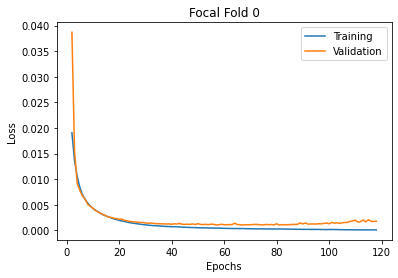

--------------------
Last epoch: 117
Term: p
Fold: 0
Fold took: 29.0 minutes 18.292149543762207 seconds to train
Last val: 0.00176700697435687
Best val: 0.00102205296085837

Precision: 0.9419141437014359
90% CI: [0.79845272 0.9925005 ]
Min, max: 0.6967547437485827 0.9933434943541033

Recall: 0.8731470506972936
90% CI: [0.76332719 0.9695854 ]
Min, max: 0.7124990786012648 0.9695968834684241

F1/Dice score: 0.9017527139069536
90% CI: [0.81960594 0.94040152]
Min, max: 0.810834515671144 0.9494387234435864

IoU: 0.8230992218448246
90% CI: [0.69435431 0.88751471]
Min, max: 0.6818517072321221 0.9037442599785401

--------------------
Starting fold: 1
Training set length: 83
Validation set length: 21
Testing set length: 20
Focal
Epoch: 50
Validation: 0.0010335079277865589.
Best: 0.0009790743157888453.
Epoch: 100
Validation: 0.000860481474470968.
Best: 0.0008271063561551273.


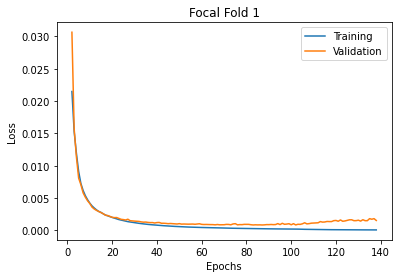

--------------------
Last epoch: 137
Term: p
Fold: 1
Fold took: 34.0 minutes 32.60091304779053 seconds to train
Last val: 0.0015255810964542131
Best val: 0.0008271063561551273

Precision: 0.9357175437752258
90% CI: [0.80590496 0.99491575]
Min, max: 0.590302441212535 0.9967205050418149

Recall: 0.8745658438501422
90% CI: [0.76270651 0.9571186 ]
Min, max: 0.5937919749919179 0.9812329107625023

F1/Dice score: 0.8970476231650121
90% CI: [0.74386507 0.94163732]
Min, max: 0.7371443243620044 0.9435550516016867

IoU: 0.8175866904388254
90% CI: [0.59218803 0.8897117 ]
Min, max: 0.5837122472364853 0.8931417136616725

--------------------
Starting fold: 2
Training set length: 83
Validation set length: 21
Testing set length: 20
Focal
Epoch: 50
Validation: 0.0013244164680751662.
Best: 0.001201132225105539.
Epoch: 100
Validation: 0.0011126269722202171.
Best: 0.0009575202129781246.


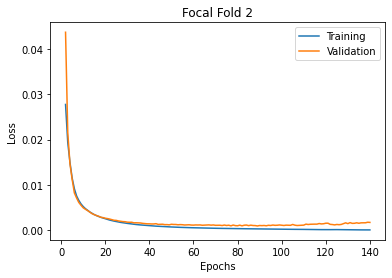

--------------------
Last epoch: 139
Term: p
Fold: 2
Fold took: 34.0 minutes 11.159184455871582 seconds to train
Last val: 0.0017375313327647746
Best val: 0.0009575202129781246

Precision: 0.9431891306881971
90% CI: [0.77349575 0.99560414]
Min, max: 0.7000576726850184 0.9966693744918779

Recall: 0.86905546871895
90% CI: [0.77849045 0.97879869]
Min, max: 0.5991892947839913 0.9794550307237418

F1/Dice score: 0.898845858262131
90% CI: [0.81311224 0.94007032]
Min, max: 0.7484292075884907 0.9459781605657979

IoU: 0.8192606901695155
90% CI: [0.68532982 0.88692073]
Min, max: 0.5979919091483653 0.8974938897600052

--------------------
Starting fold: 3
Training set length: 83
Validation set length: 21
Testing set length: 20
Focal
Epoch: 50
Validation: 0.0021983644692227244.
Best: 0.0021983644692227244.
Epoch: 100
Validation: 0.0011152475102183719.
Best: 0.0010746338909181456.
Epoch: 150
Validation: 0.0013956900608415406.
Best: 0.0009788428724277765.


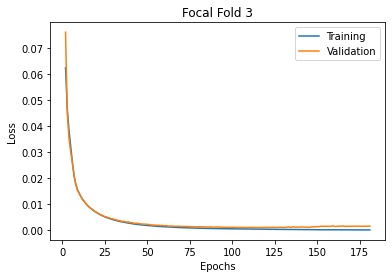

--------------------
Last epoch: 180
Term: p
Fold: 3
Fold took: 43.0 minutes 50.658358097076416 seconds to train
Last val: 0.0016189611827333767
Best val: 0.0009788428724277765

Precision: 0.9406967319324131
90% CI: [0.79994273 0.99320607]
Min, max: 0.6878683909559743 0.9969502407700654

Recall: 0.8646563158081249
90% CI: [0.77080423 0.96385358]
Min, max: 0.6067355361807687 0.9655961359202755

F1/Dice score: 0.8956964010602082
90% CI: [0.8003519  0.93185841]
Min, max: 0.7543686519803917 0.9347204161247025

IoU: 0.8137631498243284
90% CI: [0.66727997 0.87241166]
Min, max: 0.6056114862392791 0.8774414062497621

--------------------
Starting fold: 4
Training set length: 84
Validation set length: 20
Testing set length: 20
Focal
Epoch: 50
Validation: 0.0012913914863020182.
Best: 0.001281287451274693.
Epoch: 100
Validation: 0.0010978589532896876.
Best: 0.0010183469508774578.


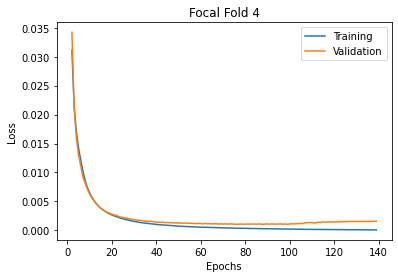

--------------------
Last epoch: 138
Term: p
Fold: 4
Fold took: 34.0 minutes 47.89730954170227 seconds to train
Last val: 0.0015766977099701761
Best val: 0.0010183469508774578

Precision: 0.9425054004351325
90% CI: [0.8290096  0.99829873]
Min, max: 0.673362068965227 0.9992210867394693

Recall: 0.8608249679963407
90% CI: [0.75615628 0.95302877]
Min, max: 0.5705434676552419 0.9627164602200267

F1/Dice score: 0.8937415870969009
90% CI: [0.78913393 0.94656839]
Min, max: 0.7260930976142416 0.9466739113559037

IoU: 0.8115295742224502
90% CI: [0.65193492 0.89855705]
Min, max: 0.5699734386040476 0.8987472365509511

--------------------

ALL FOLDS TRAINING ENDED
Mean best validation: 0.0009607738706593711
Mean precision: 0.940804590106481
Mean recall: 0.8684499294141703
Mean F1: 0.8974168366982411
Mean IOU: 0.8170478652999889



In [4]:
for TERM in TERMS:
    print("Starting term: " + TERM)
    start_term = time.time()
    
    image_folder = "/notebooks/images"
    mask_folder = "/notebooks/" + TERM
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])
    
    fold_validation = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_IOU = []
    
    for fold in FOLDS:
        print("Starting fold: {}".format(fold))
        start_fold = time.time()
        """Datasets and loaders"""
        training_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=cst.FOLDS)
        validation_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=cst.FOLDS)
        testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="test",
                                                     folds=cst.FOLDS)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)
        
        model = UNET(3, 2)
        model.to(DEVICE)
        best_model = UNET(3, 2)
        best_model = model
        
        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Loss used: Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("Loss used: IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Loss used: Tversky":
            print("Loss used: Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Loss used: Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)
        
        """Computing validation loss before training"""
        loss = validate(model, validation_loader, transform, DEVICE)
            
        best_val = loss
        best_epoch = 0
        last_epoch = 0
        
        epochs_train_losses = []
        epochs_val_losses = []
        for epoch in range(cst.EPOCHS):
            # Training
            loss = train(model, training_loader, transforms, DEVICE, criterion, optimiser)
            epochs_train_losses.append(loss)

            """Validation"""
            loss = validate(model, validation_loader, transform, DEVICE)
            epochs_val_losses.append(loss)

            # Updating best model
            if loss < best_val:
                best_val = loss
                best_model = model
                best_epoch = epoch+1

            if (epoch+1)%50 == 0:
                print("Epoch: " + str(epoch+1))
                print("Validation: {}.".format(loss))
                print("Best validation: {}.".format(best_val))
                    
            """Train and validate loops over"""
            curr = time.time()
            curr = curr - start_term
            secondes = curr % 60
            minutes = (curr-secondes)/60
            
            last_epoch = epoch
            
            # Notebooks shutdown after 6 hours. Stop the code and save the results.
            if minutes >= 350:
                break
            if (epoch - best_epoch) >= 50:
                break
            
        """All epochs are over"""
        fold_validation.append(best_val)
        
        model_name = TERM + '_' + cst.LOSS + "_Fold_" + str(fold) + "_Epoch_" + str(best_epoch) + "_MaxEpochs_" 
        model_name += str(cst.EPOCHS) + '_' + cst.OPTIMIZER + "_LR_" + str(cst.LEARNING_RATE) + ".pth"
        
        model_filepath = os.path.join(cst.MODEL, model_name)
        torch.save(best_model.state_dict(), model_filepath)
        
        # Plot losses
        index = [i+1 for i in range(last_epoch+1)]
        plt.plot(index[1:], epochs_train_losses[1:], label="Training")
        plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
        plt.title(TERM + " " + str(cst.LOSS) + " Fold " + str(fold)) 
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        
        """Evaluating"""
        precisions, recalls, F1s, IOUs = evaluate(best_model, testing_loader)
        
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(F1s)
        mean_IOU = np.mean(IOUs)
        
        fold_precision.append(mean_precision)
        fold_recall.append(mean_recall)
        fold_f1.append(mean_f1)
        fold_IOU.append(mean_IOU)
        
        confidence = 0.9
        
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60
        #print("--------------------")
        print("Last epoch: {}".format(last_epoch))
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Fold took: " + str(minutes) + " minutes " + str(secondes) + " seconds to train")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print()
        print("Precision: {}".format(mean_precision))
        print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(precisions), np.max(precisions))
        print()

        print("Recall: {}".format(mean_recall))
        print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(recalls), np.max(recalls))
        print()

        print("F1/Dice score: {}".format(mean_f1))
        print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(F1s), np.max(F1s))
        print()

        print("IoU: {}".format(mean_IOU))
        print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(IOUs), np.max(IOUs))
        print()
        print("--------------------")
    """Fold loop end"""
    print()
    print("ALL FOLDS TRAINING ENDED")
    print("Mean best validation: {}".format(np.mean(fold_validation)))
    print("Mean precision: {}".format(np.mean(fold_precision)))
    print("Mean recall: {}".format(np.mean(fold_recall)))
    print("Mean F1: {}".format(np.mean(fold_f1)))
    print("Mean IOU: {}".format(np.mean(fold_IOU)))
"""term loop end"""
print()